In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
LR = 0.0003
UP_COEF = 0.05
GAMMA = 0.99
EPS = 1e-8

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)
    # double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        is_done = 1. - d.detach().reshape(BATCH_SIZE, 1).to(device).float()
        
        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            done_mask = torch.cat(tuple(is_done for _ in range(action_space)), dim=1)
            _q_batch_tgt_masked = _q_batch_tgt * done_mask
            _q_best_tgt = _q_batch_tgt_masked[range(BATCH_SIZE), _a_batch]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA*_q_best_tgt) - q_acting).pow(2).sum().mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q)

    return action.item()

## main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 0.001
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)

# make optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
use_cuda

True

In [7]:
env.spec.max_episode_steps

500

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

475.0

In [10]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
        env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
        
        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                break
env.close()

  1 Episode in    10 steps, reward 10.00
  2 Episode in    20 steps, reward 10.00
  3 Episode in    28 steps, reward 8.00
  4 Episode in    36 steps, reward 8.00
  5 Episode in    44 steps, reward 8.00
  6 Episode in    53 steps, reward 9.00
  7 Episode in    63 steps, reward 10.00
  8 Episode in    71 steps, reward 8.00
  9 Episode in    80 steps, reward 9.00
 10 Episode in    89 steps, reward 9.00
 11 Episode in    99 steps, reward 10.00
 12 Episode in   109 steps, reward 10.00
 13 Episode in   119 steps, reward 10.00
 14 Episode in   129 steps, reward 10.00
 15 Episode in   138 steps, reward 9.00
 16 Episode in   146 steps, reward 8.00
 17 Episode in   155 steps, reward 9.00
 18 Episode in   165 steps, reward 10.00
 19 Episode in   175 steps, reward 10.00
 20 Episode in   185 steps, reward 10.00
 21 Episode in   195 steps, reward 10.00
 22 Episode in   205 steps, reward 10.00
 23 Episode in   215 steps, reward 10.00
 24 Episode in   223 steps, reward 8.00
 25 Episode in   231 steps,

204 Episode in  1922 steps, reward 12.00
205 Episode in  1931 steps, reward 9.00
206 Episode in  1942 steps, reward 11.00
207 Episode in  1954 steps, reward 12.00
208 Episode in  1965 steps, reward 11.00
209 Episode in  1973 steps, reward 8.00
210 Episode in  1982 steps, reward 9.00
211 Episode in  1992 steps, reward 10.00
212 Episode in  2000 steps, reward 8.00
213 Episode in  2010 steps, reward 10.00
214 Episode in  2018 steps, reward 8.00
215 Episode in  2027 steps, reward 9.00
216 Episode in  2037 steps, reward 10.00
217 Episode in  2047 steps, reward 10.00
218 Episode in  2055 steps, reward 8.00
219 Episode in  2064 steps, reward 9.00
220 Episode in  2074 steps, reward 10.00
221 Episode in  2082 steps, reward 8.00
222 Episode in  2091 steps, reward 9.00
223 Episode in  2099 steps, reward 8.00
224 Episode in  2109 steps, reward 10.00
225 Episode in  2119 steps, reward 10.00
226 Episode in  2129 steps, reward 10.00
227 Episode in  2139 steps, reward 10.00
228 Episode in  2148 steps,

401 Episode in 65368 steps, reward 500.00
402 Episode in 65868 steps, reward 500.00
403 Episode in 66368 steps, reward 500.00
404 Episode in 66868 steps, reward 500.00
405 Episode in 67368 steps, reward 500.00
406 Episode in 67868 steps, reward 500.00
407 Episode in 68368 steps, reward 500.00
408 Episode in 68868 steps, reward 500.00
409 Episode in 69368 steps, reward 500.00
410 Episode in 69868 steps, reward 500.00
411 Episode in 70368 steps, reward 500.00
412 Episode in 70868 steps, reward 500.00
413 Episode in 71368 steps, reward 500.00
414 Episode in 71868 steps, reward 500.00
415 Episode in 72368 steps, reward 500.00
416 Episode in 72868 steps, reward 500.00
417 Episode in 73368 steps, reward 500.00
418 Episode in 73868 steps, reward 500.00
419 Episode in 74368 steps, reward 500.00
420 Episode in 74868 steps, reward 500.00
421 Episode in 75368 steps, reward 500.00
422 Episode in 75868 steps, reward 500.00
423 Episode in 76368 steps, reward 500.00
424 Episode in 76868 steps, reward

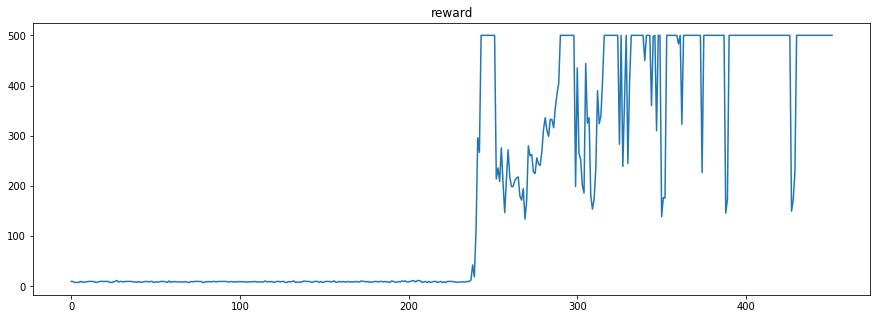

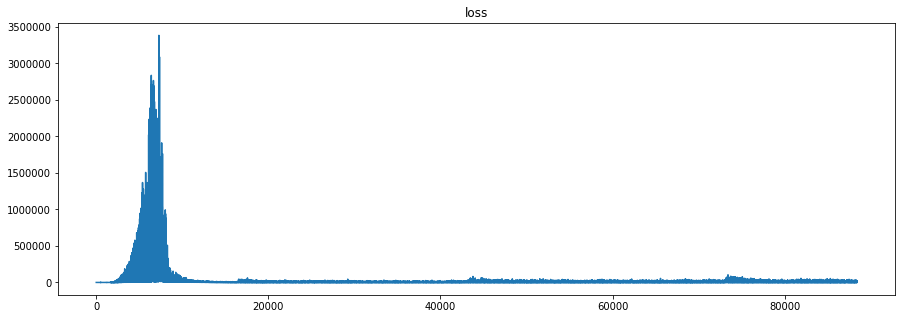

In [11]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('loss')
plt.plot(losses)
plt.show()

In [12]:
[
    ('CartPole-v0', 412, 1),
    ('CartPole-v1', 452, 0.05),
    ('MountainCar-v0', 193, 0.1),
]

[('CartPole-v0', 412, 1),
 ('CartPole-v1', 509, 0.1),
 ('MountainCar-v0', 193, 0.1)]